# The Single Stock - analysis

The notebook here allows to perform analysis for a single exchange security (shares).

### Data downloading

In [1]:
start = '2012-01-01'
end = '2017-12-31'
stock_symbol = 'SLV'

# Uncomment line below to download latest quotes for stocks
#%run ../money_machine_app/downloaders/stocks_data_downloader.py $start $end $stock_symbol

### Analysis

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# The CSV file has following columns: 
# Data, Otwarcie, Najwyzszy, Najnizszy, Zamkniecie, Wolumen

stock = pd.read_csv('../data-archive/stocks/SLV.csv',
                   delimiter=',',
                   index_col='Data',
                   parse_dates=True)

In [4]:
# drop unnecessary columns
stock.drop(['Otwarcie', 'Najwyzszy', 'Najnizszy', 'Wolumen'], axis=1, inplace=True)

# rename column and index
stock.columns = ['Close']
stock.index.names = ['Date']

### Normalize Price

This is same as cumulative daily returns

In [5]:
stock['Normed Return'] = stock['Close'] / stock.iloc[0]['Close']

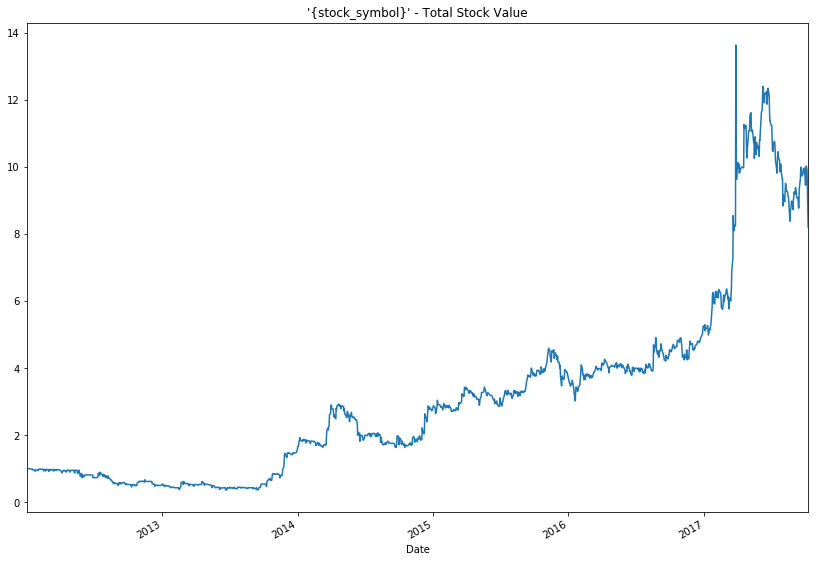

In [6]:
stock['Normed Return'].plot(figsize=(14,10))
plt.title("'{stock_symbol}' - Total Stock Value");